In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

from bs4 import BeautifulSoup
import requests as rq

from tqdm import tqdm

In [2]:
id_match = 0
match_tab = []
player_stats_tab = []

for i in tqdm(range(1, 5)):
    if i == 1:
        url = "https://lol.fandom.com/wiki/LEC/2023_Season/Spring_Season/Scoreboards"
    elif i == 4:
        url = "https://lol.fandom.com/wiki/LEC/2023_Season/Spring_Season/Scoreboards/Tiebreakers"
    else:
        url = f"https://lol.fandom.com/wiki/LEC/2023_Season/Spring_Season/Scoreboards/Week_{i}"

    response = rq.get(url)
    soup = BeautifulSoup(response.text)

    if not response.ok:
        print("Problème de connection... Cette url :", url, "n'existe pas")
        continue
    
    if i == 4:
        result_tab = soup.find_all("tbody")[-1:]
    else:
        result_tab = soup.find_all("tbody")[-15:]

    for tab in result_tab:
        #Chercher le nom des teams
        tmp_teamnames = tab.findAll("span", {"class" : "teamname"})
        teamnames = []
        for tn in tmp_teamnames:
            teamnames.append(tn.text)

        #Quel side gagne
        side_blue = tab.find("th", {"class" : "side-blue"}).text

        #Gold par team
        tmp_gold_teams = tab.findAll("div", {"class" : "sb-header-Gold"})
        gold_teams = []
        for gt in tmp_gold_teams:
            gold_teams.append(gt.text)

        #Kill par team
        tmp_kills_teams = tab.findAll("div", {"class" : "sb-header-Kills"})
        kills_teams = []
        for kt in tmp_kills_teams:
            kills_teams.append(kt.text)

        #Durée de jeu
        tr = tab.findAll("tr")[2]
        game_time = tr.findAll("th")[1].text

        #Scoreboard
        scoreboards = [tab.find("td", {"class" : "side-blue"}), tab.find("td", {"class" : "side-red"})]
        stats = []
        for sb in scoreboards:

            #Player
            div = sb.findAll("div", {"class" : "sb-p-name"})
            side_player = []
            for dv in div:
                side_player.append(dv.text)

            #Composition
            span = sb.findAll("span", {"class" : "sprite champion-sprite"})
            side_perso = []
            for sp in span:
                side_perso.append(sp.attrs["title"])

            #KDA
            div = sb.findAll("div", {"class" : "sb-p-stat sb-p-stat-kda"})
            side_kda = []
            for dv in div:
                side_kda.append(dv.text)

            #CSing
            div = sb.findAll("div", {"class" : "sb-p-stat sb-p-stat-cs"})
            side_cs = []
            for dv in div:
                side_cs.append(dv.text)

            #Gold par joueur
            div = sb.findAll("div", {"class" : "sb-p-stat sb-p-stat-gold"})
            side_gold = []
            for dv in div:
                side_gold.append(dv.text)

            postes = ["Top", "Jungle", "Mid", "Adc", "Support"]
            k = 0
            for play, comp, kda, cs, gold in zip(side_player, side_perso, side_kda, side_cs, side_gold):
                stats.append((postes[k], play, comp, kda, cs, gold))
                k += 1

        #Bans
        div = [tab.findAll("div", {"class" : "sb-footer-bans"})[1], tab.findAll("div", {"class" : "sb-footer-bans"})[3]] 
        team_bans = []
        for dv in div:
            span = dv.findAll("span", {"class" : "sprite champion-sprite"})
            side_bans = []
            for sp in span:
                side_bans.append(sp.attrs["title"])
            team_bans.append(side_bans)

        #Game stats
        divs = tab.findAll("div", {"class": "sb-footer-stats"})
        game_stats = []
        for div in divs:
            side_stats = []
            divs_stats = div.findAll("div")
            for dv in divs_stats:
                side_stats.append(int(dv.text))
            game_stats.append(side_stats)


        side = "Blue"
        for team, gt, kt, tb, gs in zip(teamnames, gold_teams, kills_teams, team_bans, game_stats):
            win = (side == "Blue" and side_blue == "1") or (side == "Red" and side_blue == "0")
            match_tab.append([id_match, team, float(gt[:-1]), int(kt), side, float(f"{game_time.split(':')[0]}.{game_time.split(':')[1]}"), "Win" if win else "Lose", tb] + gs)
            side = "Red"

        side = "Blue"
        k=0
        for team in teamnames:
            win = (side == "Blue" and side_blue == "1") or (side == "Red" and side_blue == "0")
            for poste, play, comp, kda, cs, gold in stats[k:k+5]:
                kill, death, assist = kda.split('/')
                player_stats_tab.append([id_match, team, poste, play, comp, int(kill), int(death), int(assist), int(cs), float(gold[:-1]), side, float(f"{game_time.split(':')[0]}.{game_time.split(':')[1]}"), "Win" if win else "Lose"])
            side = "Red"
            k=5

        id_match += 1

100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


In [3]:
player_stats = pd.DataFrame(
    player_stats_tab, 
    index=range(len(player_stats_tab)), 
    columns=["Id Match", "Team", "Poste", "Player", "Champion", "Kill", "Death", "Assist", "CS", "KGolds", "Side", "Game time", "Win"]
)

matchs = pd.DataFrame(
    match_tab, 
    index=range(len(match_tab)), 
    columns=["Id Match", "Team", "KGolds", "Kills", "Side",  "Game time", "Win", "Bans", "Turrets", "Inhibitors", "Nashors", "Dragons", "Heralds"]
)

In [4]:
teams = matchs["Team"].value_counts().index
champions = player_stats["Champion"].value_counts().index
postes = player_stats["Poste"].value_counts().index

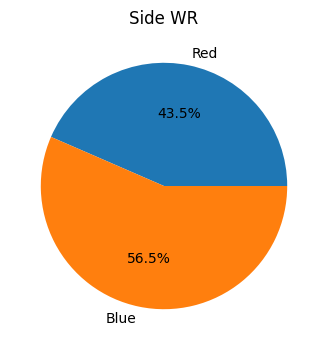

In [5]:
side_wr = matchs.groupby(["Side", "Win"])["Id Match"].count()["Blue"]
side_wr.index = ["Red", "Blue"]
side_wr.plot(kind="pie", autopct='%1.1f%%', figsize=(4, 4), title="Side WR", ylabel="")
plt.show()

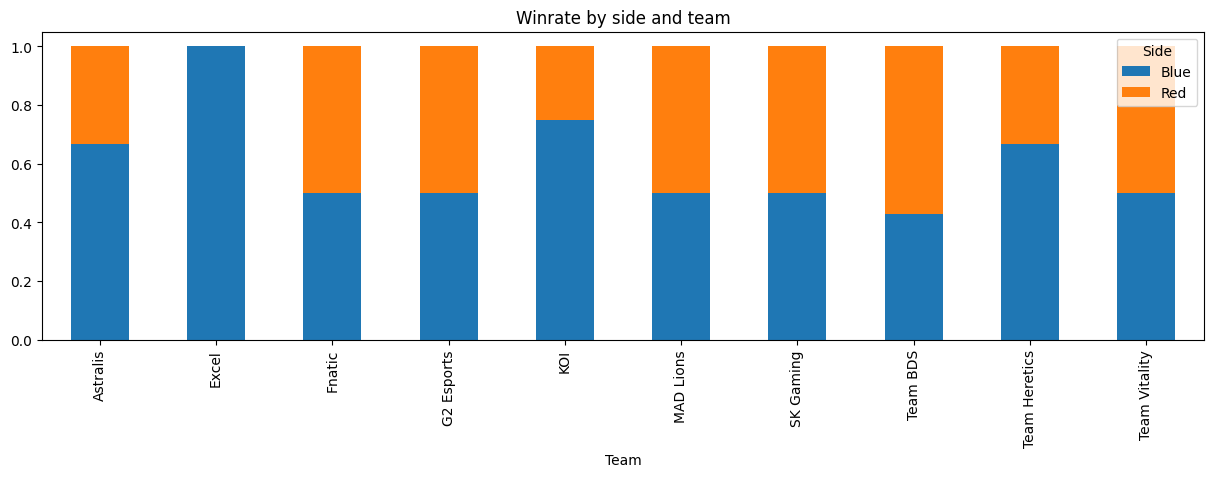

In [6]:
side_wr_by_team = matchs[matchs["Win"] == "Win"].groupby(["Team", "Side"])["Id Match"].count().unstack().fillna(0)
side_wr_by_team /= side_wr_by_team.sum(axis=1).values.reshape(-1, 1)
side_wr_by_team.plot(kind="bar", stacked=True, figsize=(15, 4), title="Winrate by side and team")
plt.show()

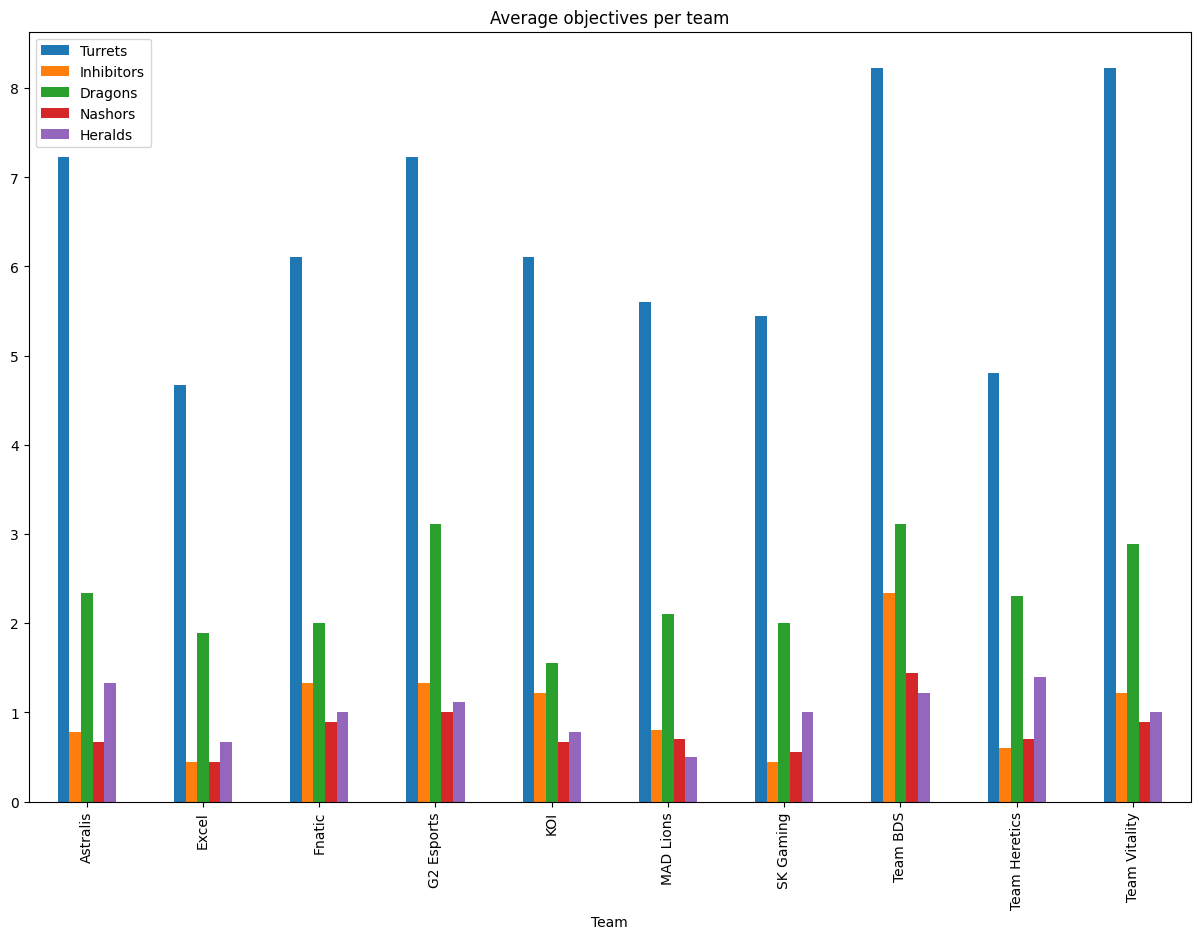

In [7]:
matchs.groupby(["Team"])[["Turrets", "Inhibitors", "Dragons", "Nashors", "Heralds"]].mean().plot(kind="bar", figsize=(15, 10), title="Average objectives per team")
plt.show()

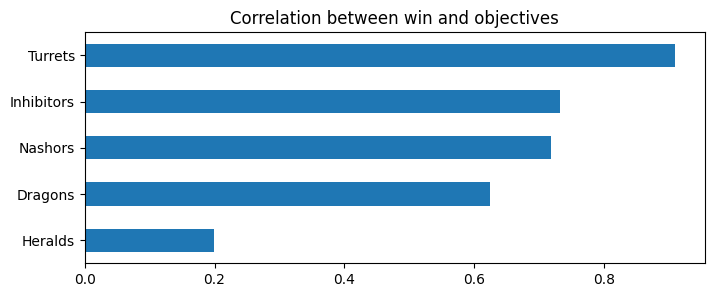

In [8]:
win_stats = matchs[["Win", "Turrets", "Inhibitors", "Nashors", "Dragons", "Heralds"]].copy()
win_stats["Win"] = win_stats["Win"].map({"Win": 1, "Lose": 0})
win_stats.corr()["Win"][1:].sort_values(ascending=True).plot(kind="barh", figsize=(8, 3), title="Correlation between win and objectives")
plt.show()

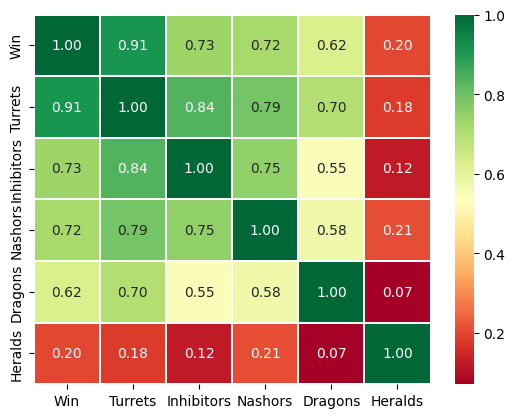

In [9]:
sbn.heatmap(win_stats.corr(), annot=True, fmt='.2f', cmap='RdYlGn', linewidths=0.2)
plt.show()

In [10]:
champ_wr = player_stats.groupby(["Champion", "Win"])["Id Match"].count().unstack().fillna(0)
row_sum = champ_wr.sum(axis=1).values.reshape(-1, 1)
champ_wr /= row_sum
champ_wr = champ_wr[["Win"]]
champ_wr.columns = ["Winrate"]
champ_wr["Nb games"] = row_sum

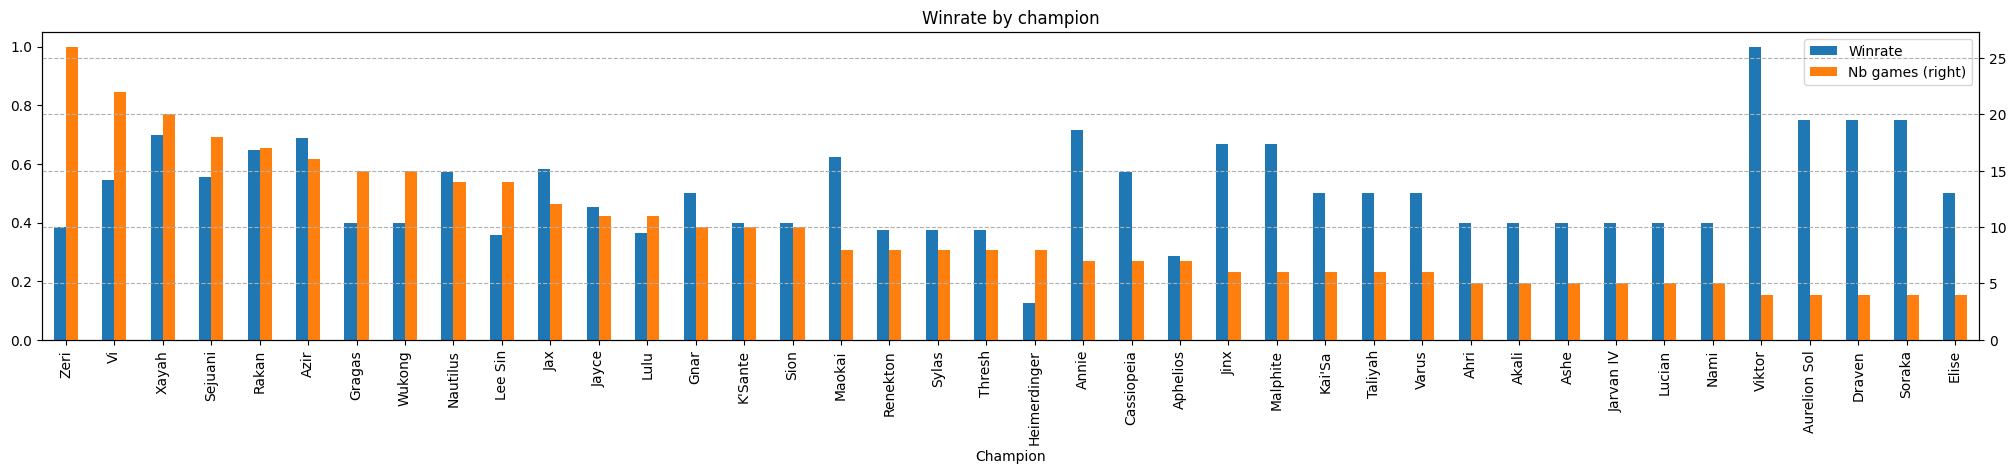

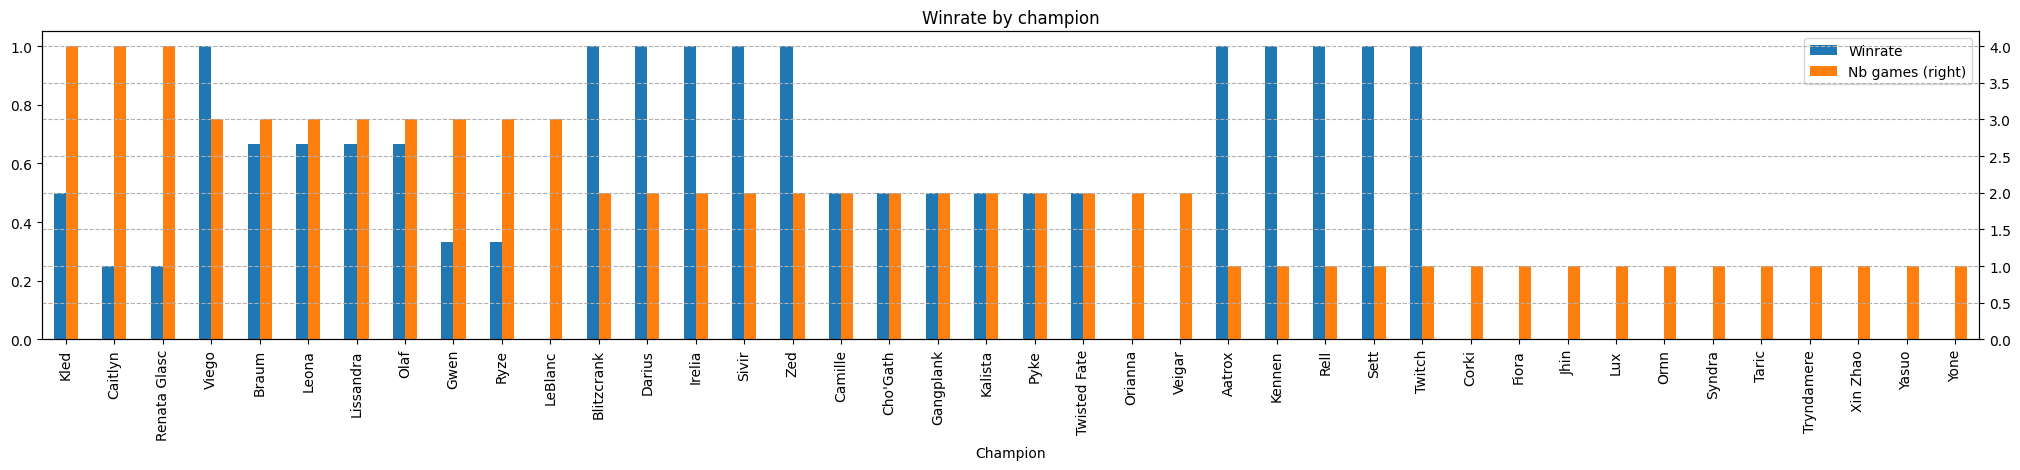

In [11]:
L = 40
N = champ_wr.shape[0]/L
for i in range(0, int(N)):
    champ_wr.sort_values(ascending=False, by=["Nb games", "Winrate"])[i*L:(i+1)*L].plot(kind="bar", figsize=(25, 4), title="Winrate by champion", stacked=False, secondary_y="Nb games", legend=True)
    plt.grid(axis="y", linestyle="--")
    plt.show()

In [12]:
champ_wr_by_team = player_stats.groupby(["Team", "Champion", "Win"])["Id Match"].count().unstack().fillna(0)
champ_wr_by_team /= champ_wr_by_team.sum(axis=1).values.reshape(-1, 1)
champ_wr_by_team = champ_wr_by_team["Win"]

In [13]:
champ_wr_by_team = player_stats.groupby(["Team", "Champion", "Win"])["Id Match"].count().unstack().fillna(0)
row_sum = champ_wr_by_team.sum(axis=1).values.reshape(-1, 1)
champ_wr_by_team /= row_sum
champ_wr_by_team = champ_wr_by_team[["Win"]]
champ_wr_by_team.columns = ["Winrate"]
champ_wr_by_team["Nb games"] = row_sum

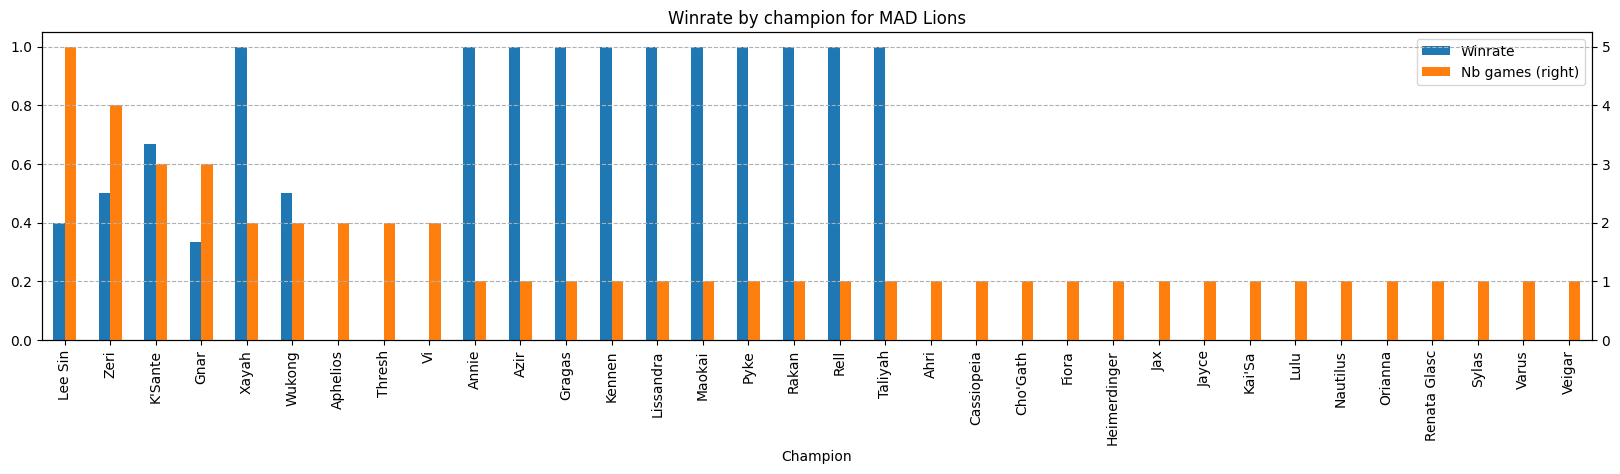

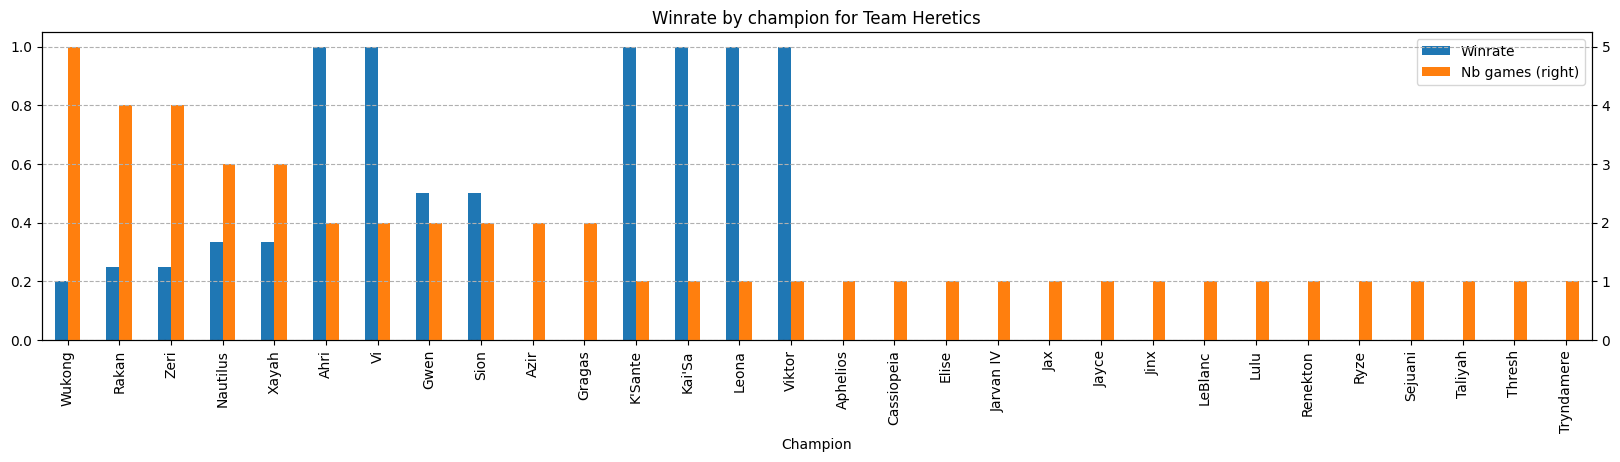

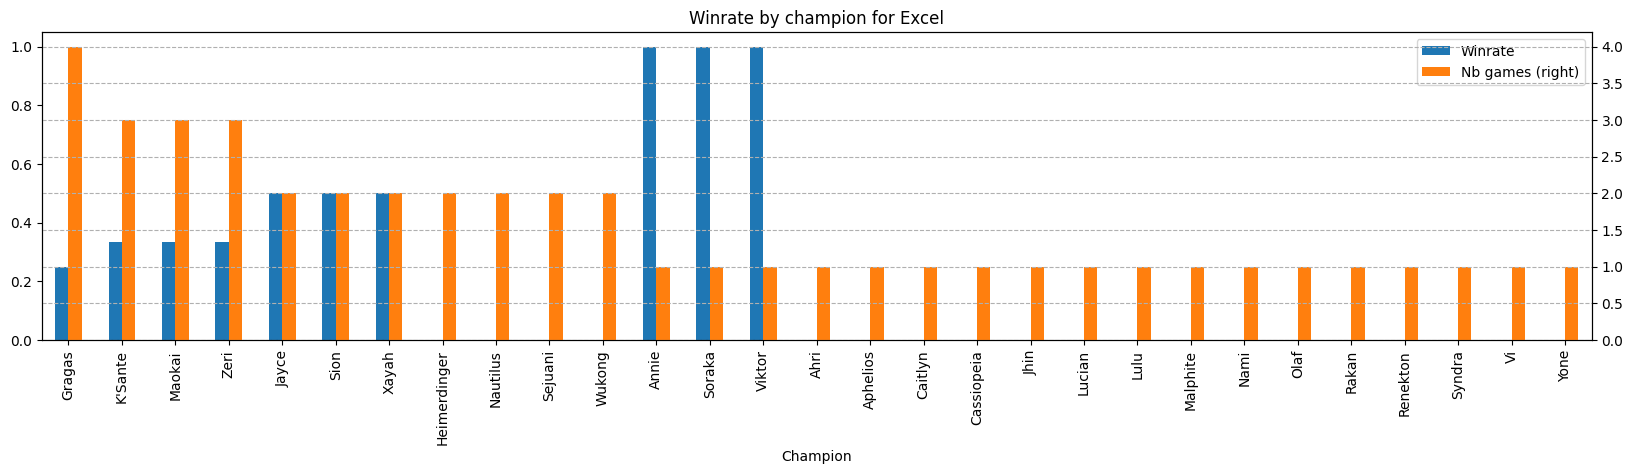

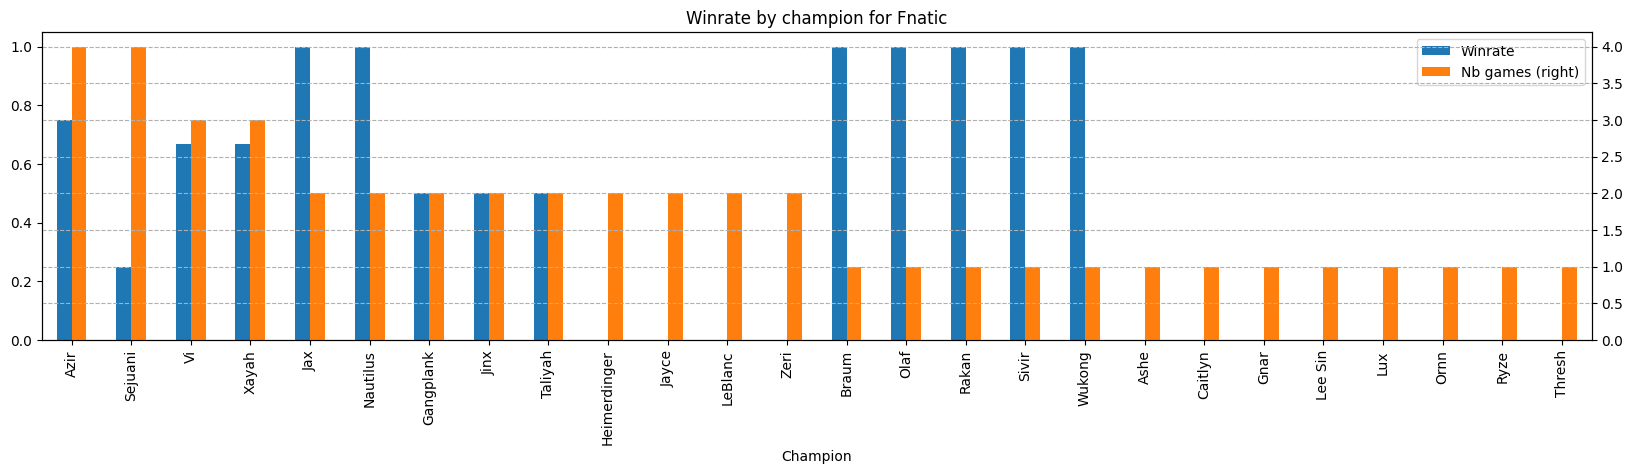

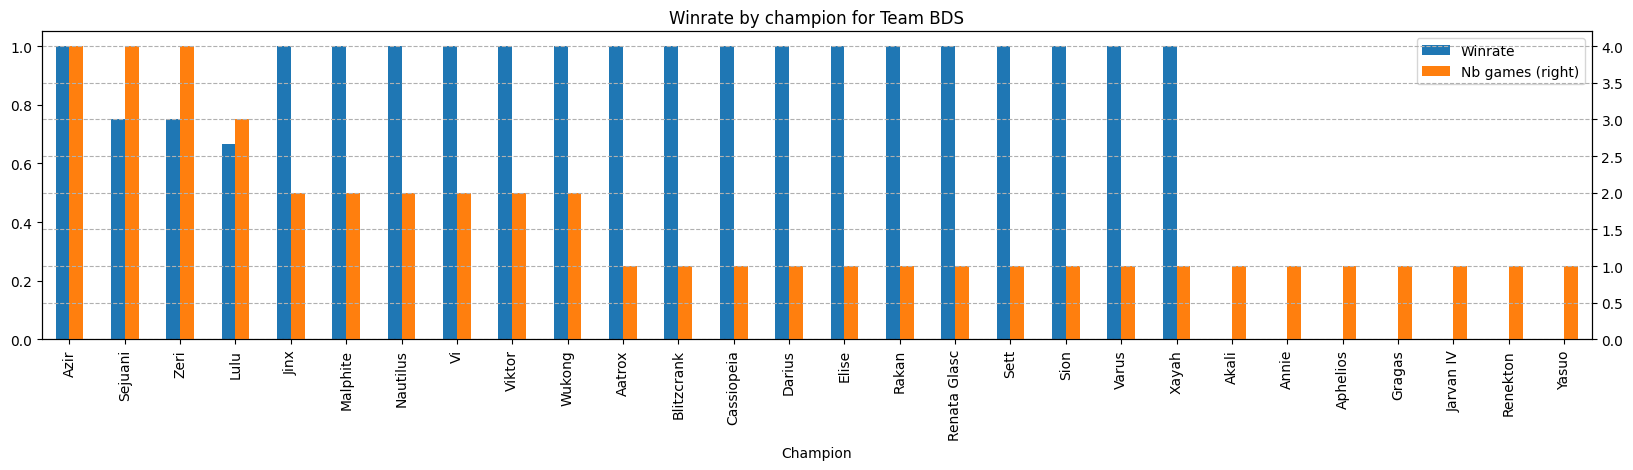

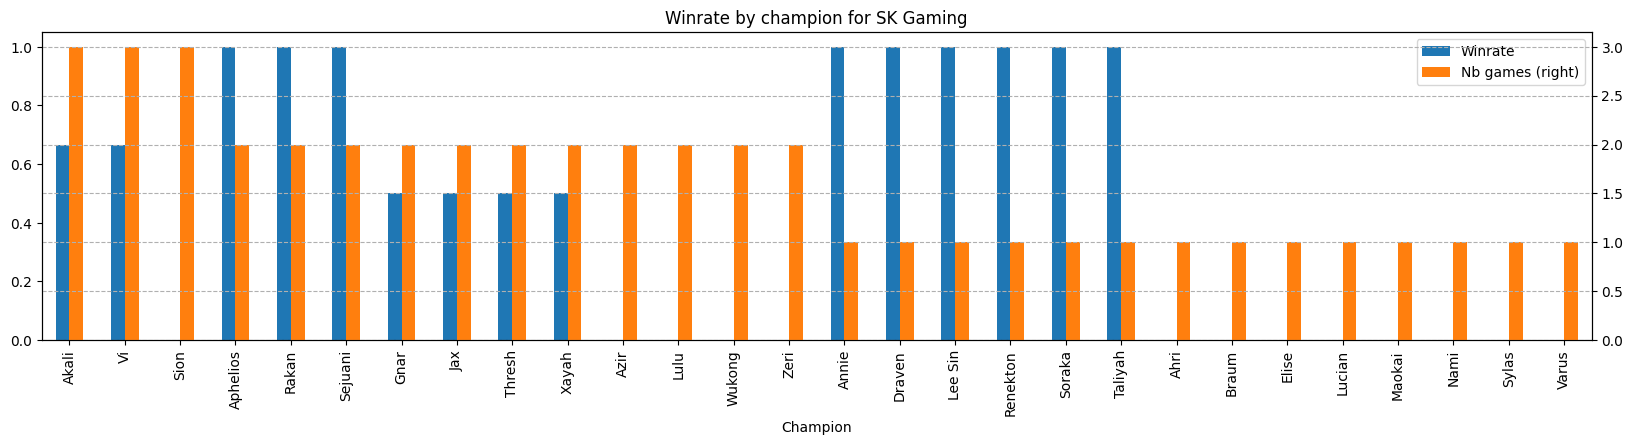

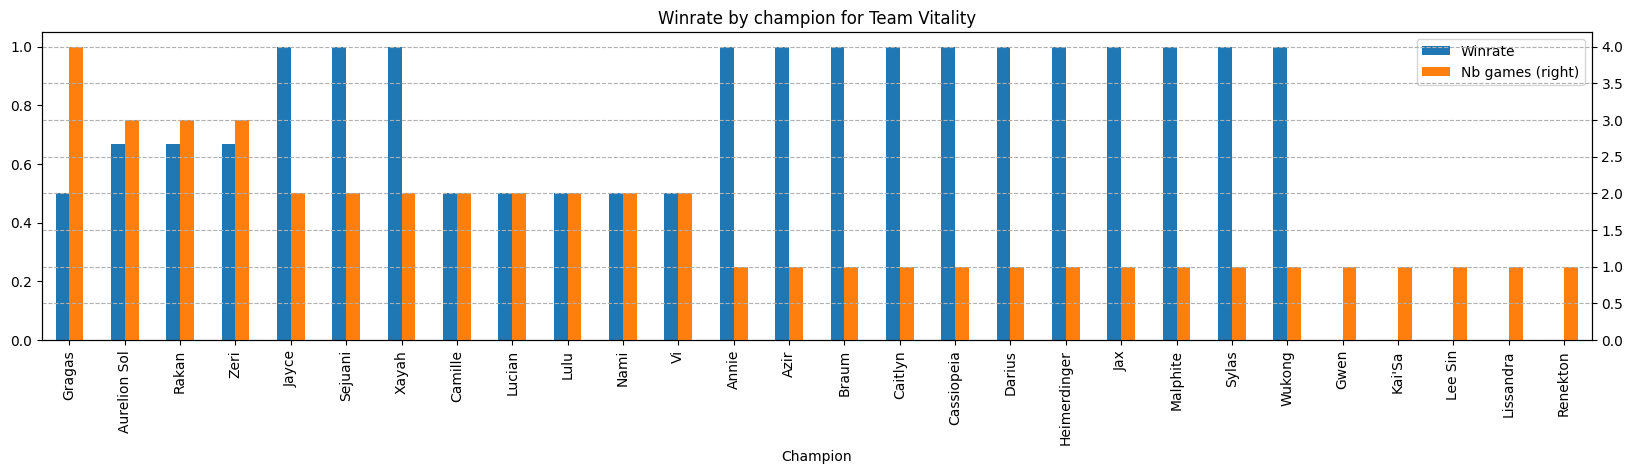

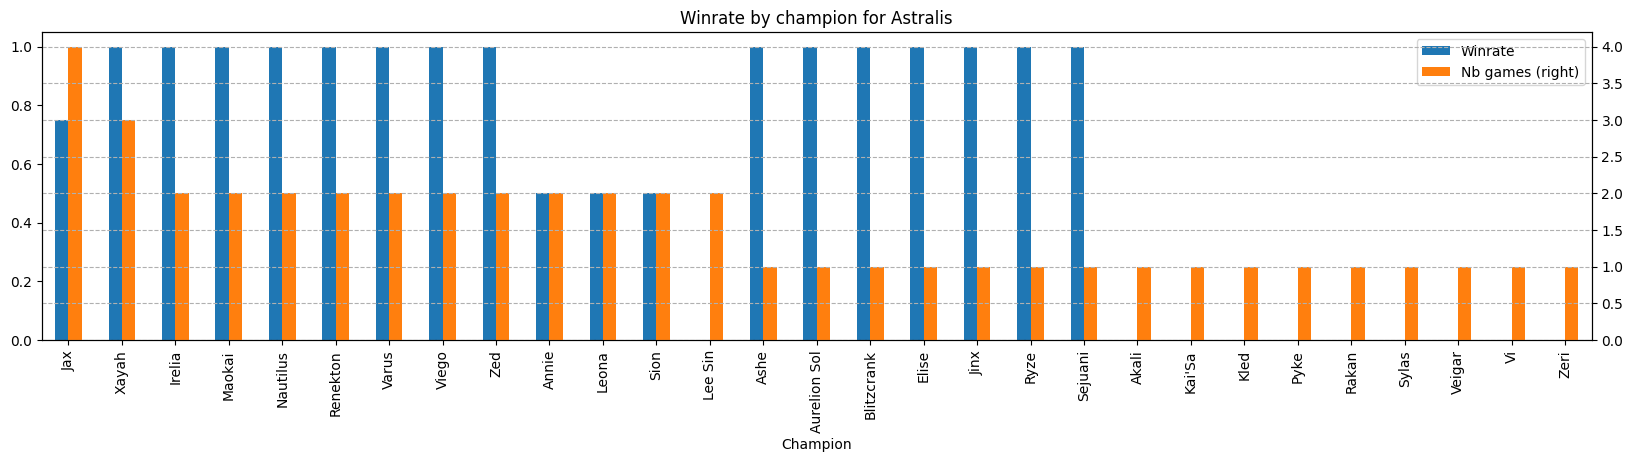

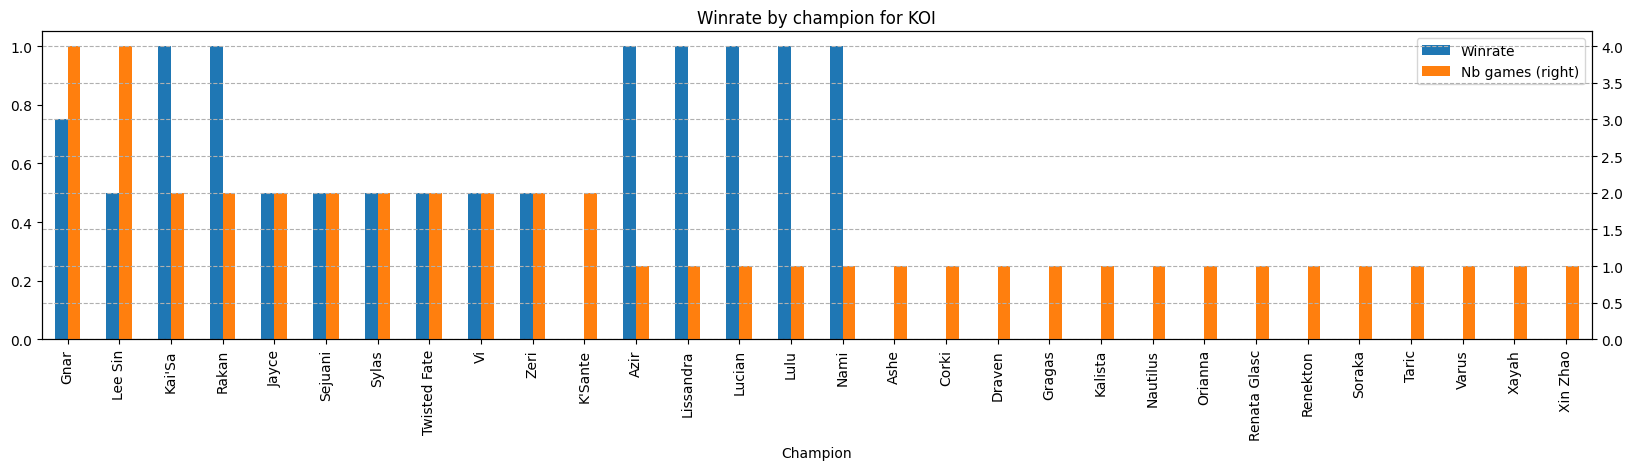

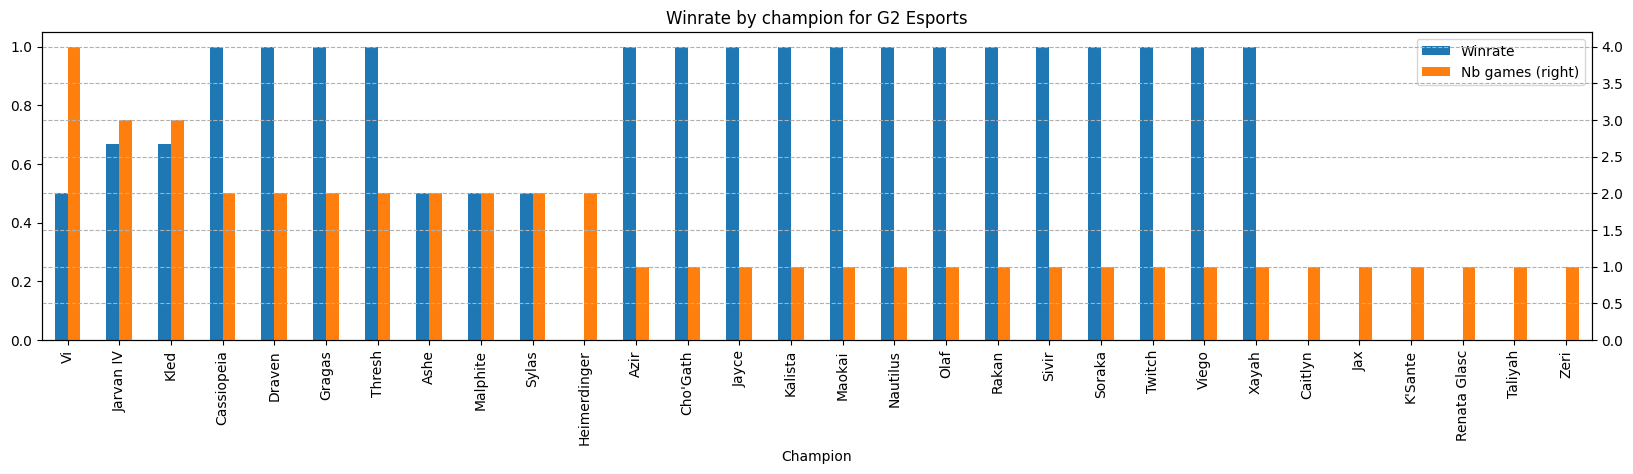

In [14]:
for team in teams:
    champ_wr_by_team.loc[team].sort_values(ascending=False, by=["Nb games", "Winrate"]).plot(kind="bar", figsize=(20, 4), title=f"Winrate by champion for {team}", stacked=False, secondary_y="Nb games", legend=True)
    plt.grid(axis="y", linestyle="--")
    plt.show()

In [15]:
ban_wr = matchs.explode("Bans").groupby(["Bans", "Win"])["Id Match"].count().unstack().fillna(0)
row_sum = ban_wr.sum(axis=1).values.reshape(-1, 1)
ban_wr /= row_sum
ban_wr = ban_wr[["Win"]]
ban_wr.columns = ["Banrate"]
ban_wr["Nb bans"] = row_sum

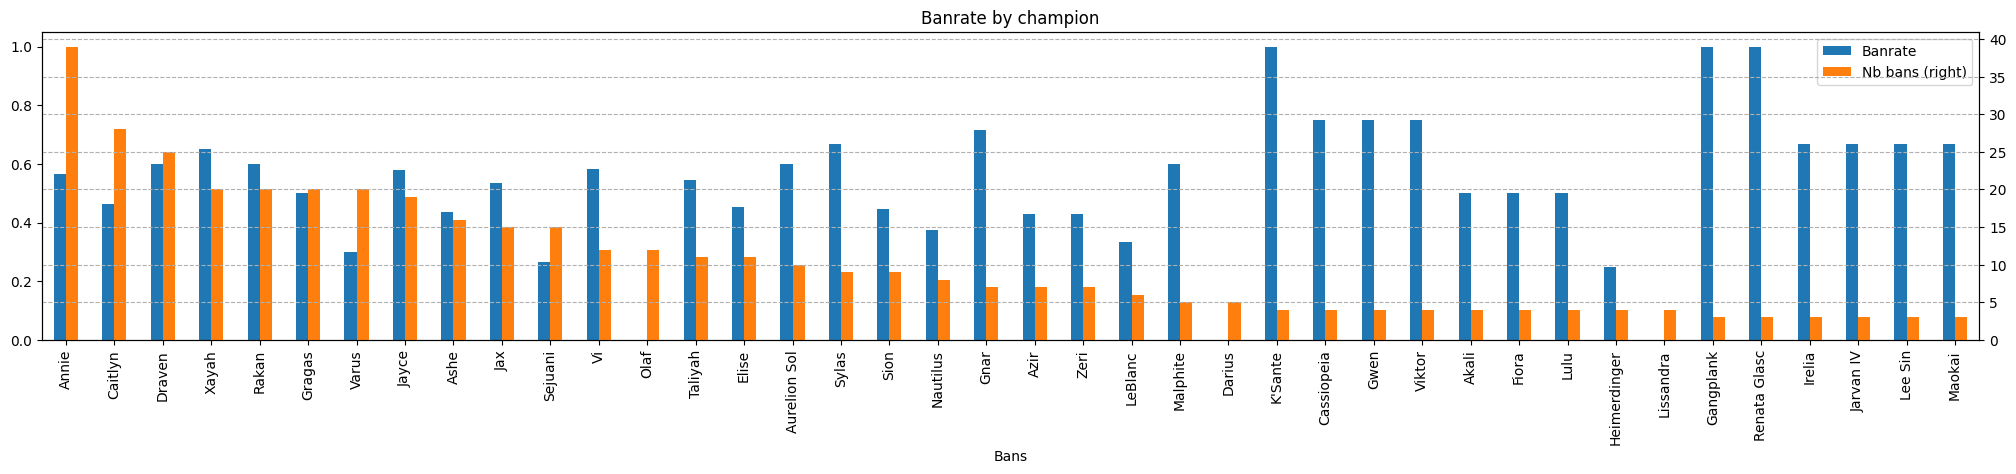

In [16]:
L = 40
N = ban_wr.shape[0]/L
for i in range(0, int(N)):
    ban_wr.sort_values(ascending=False, by=["Nb bans", "Banrate"])[i*L:(i+1)*L].plot(kind="bar", figsize=(25, 4), title="Banrate by champion", stacked=False, secondary_y="Nb bans", legend=True)
    plt.grid(axis="y", linestyle="--")
    plt.show()

In [17]:
ban_wr_by_team = matchs.explode("Bans").groupby(["Team", "Bans", "Win"])["Id Match"].count().unstack().fillna(0)
row_sum = ban_wr_by_team.sum(axis=1).values.reshape(-1, 1)
ban_wr_by_team /= row_sum
ban_wr_by_team = ban_wr_by_team[["Win"]]
ban_wr_by_team.columns = ["Banrate"]
ban_wr_by_team["Nb bans"] = row_sum

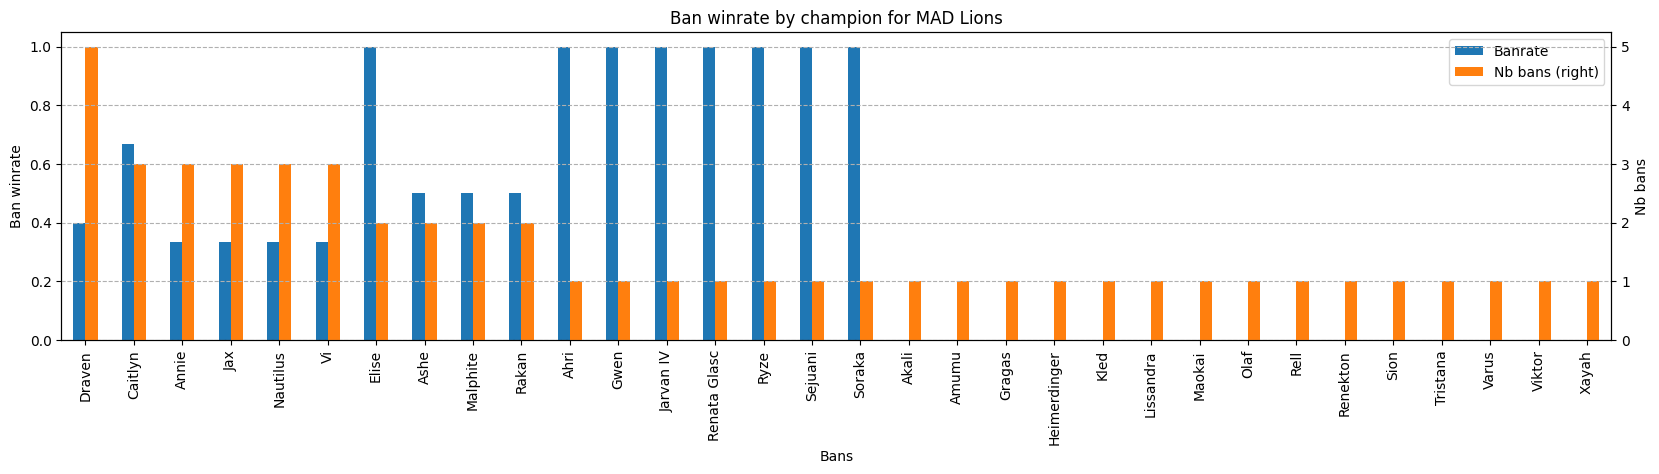

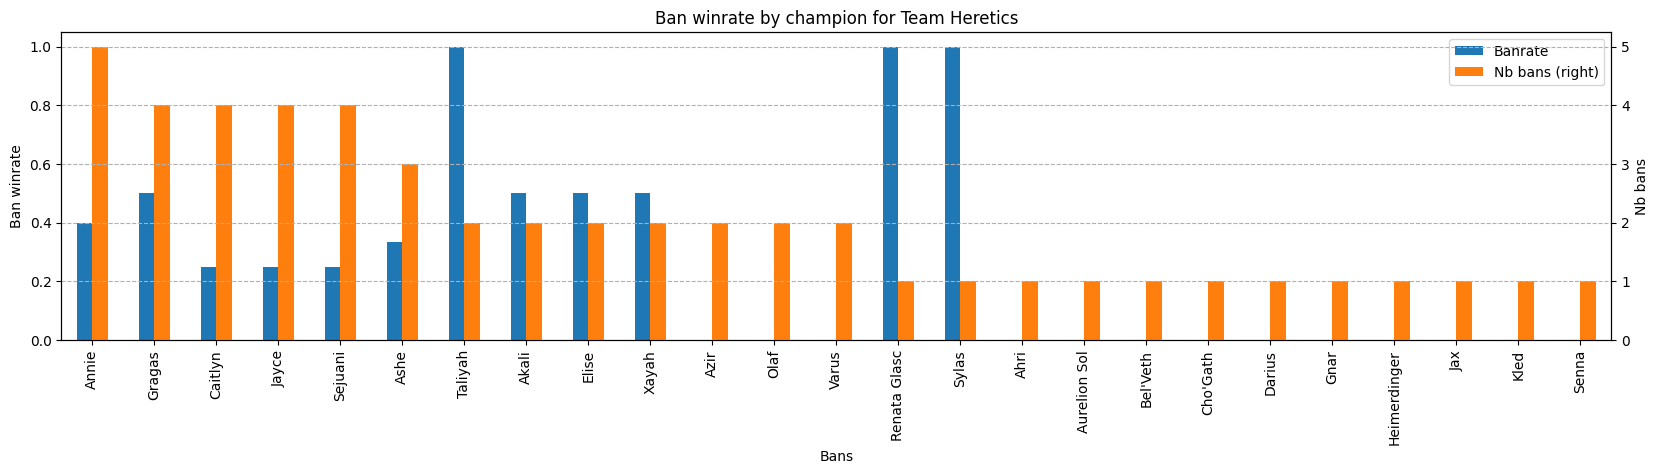

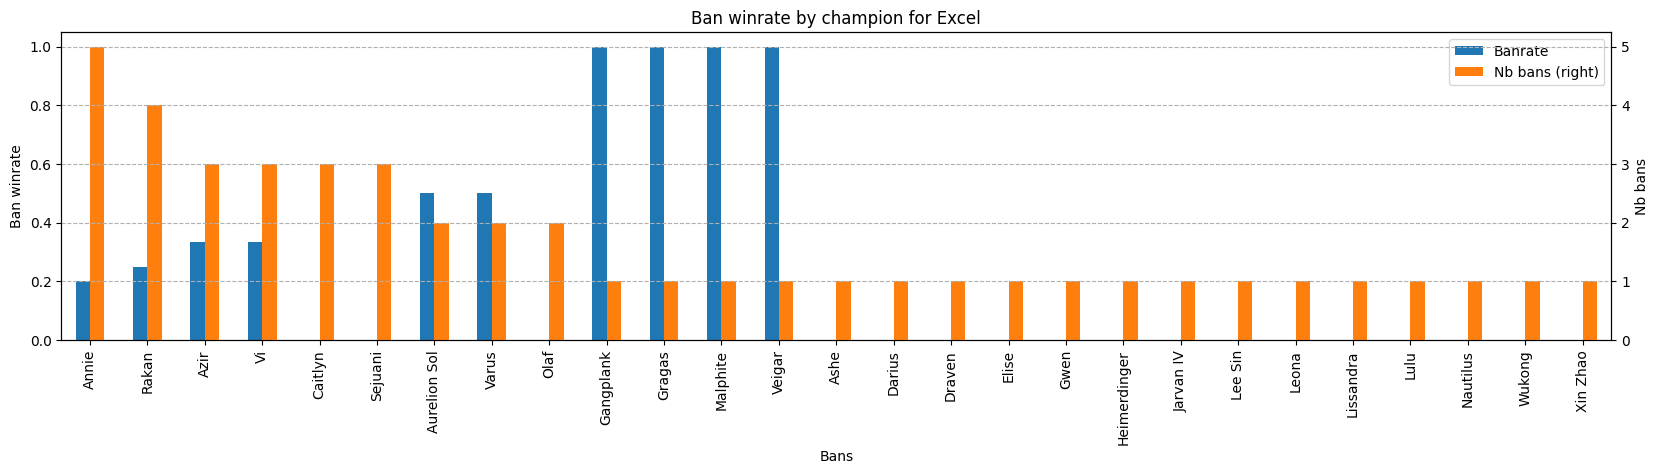

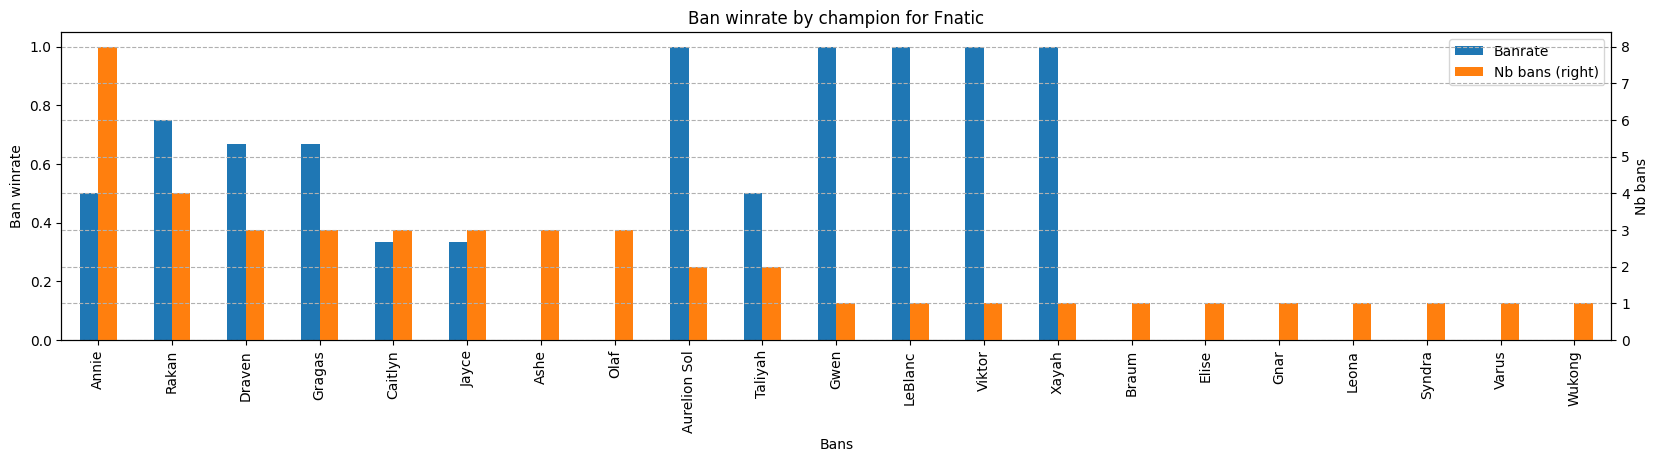

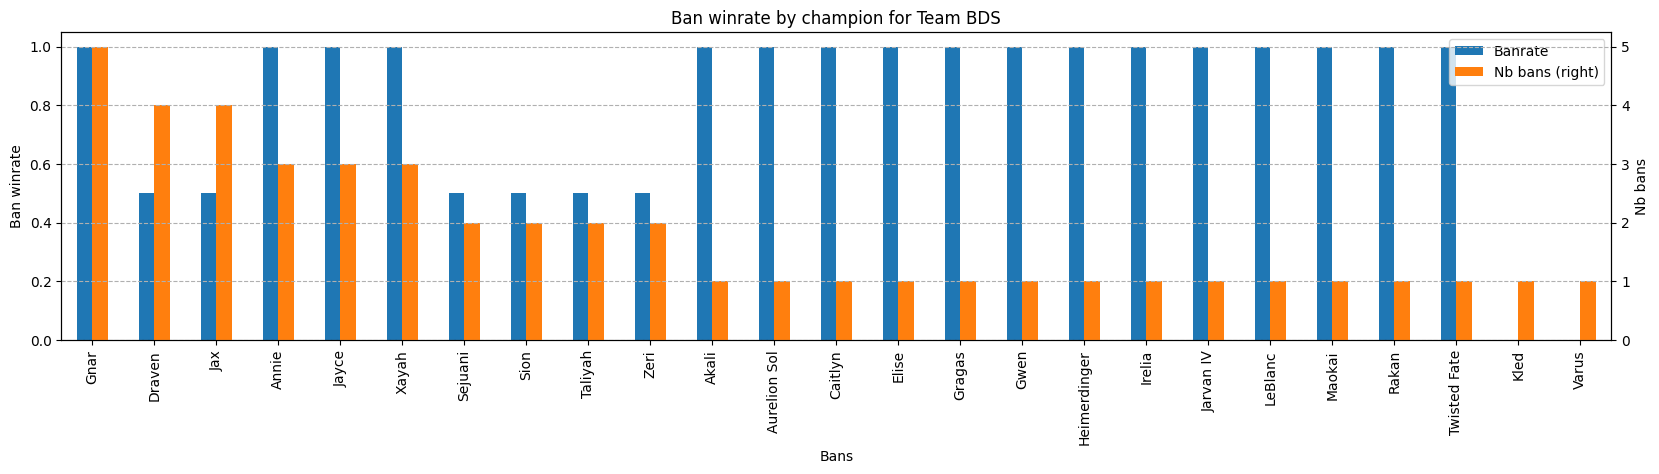

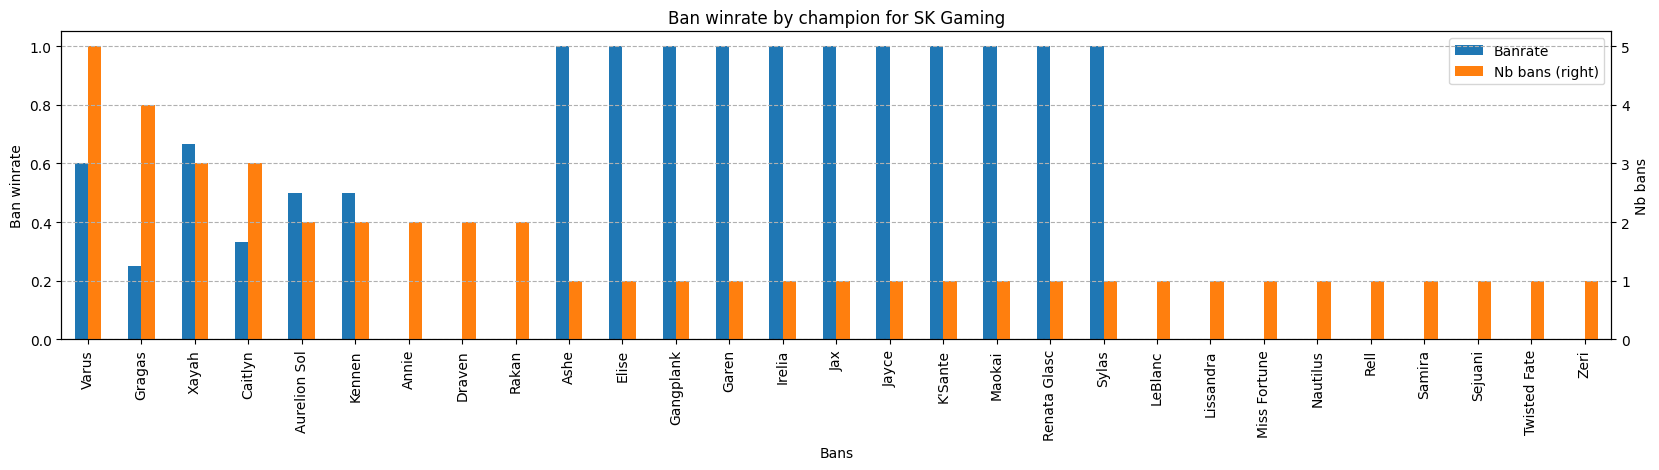

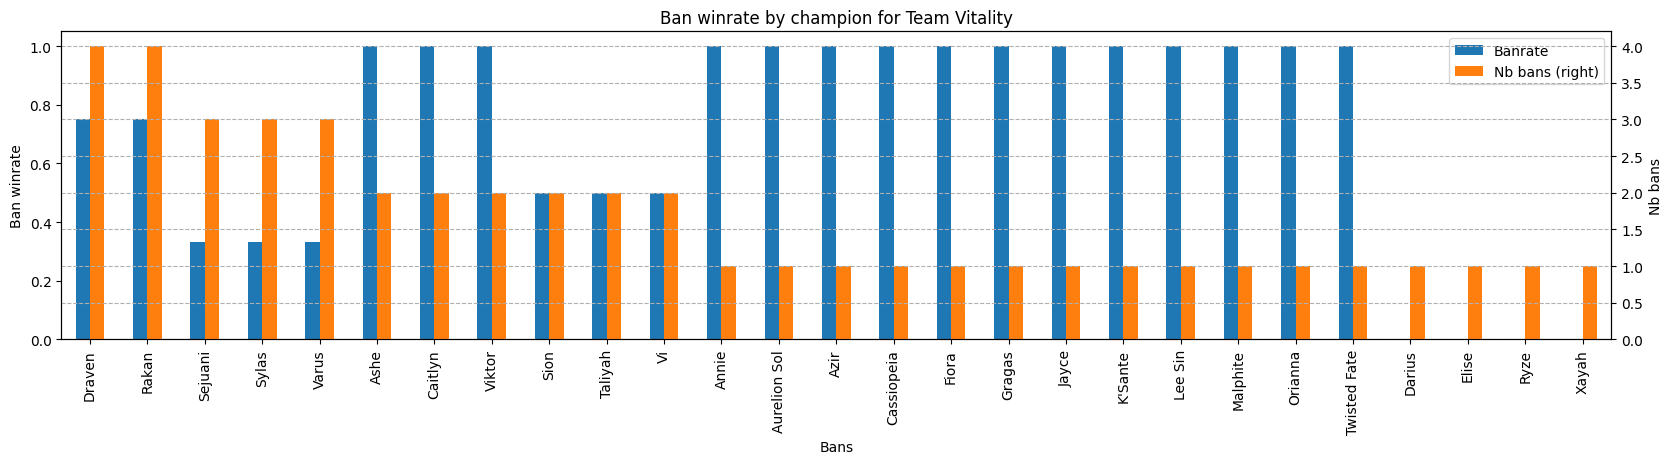

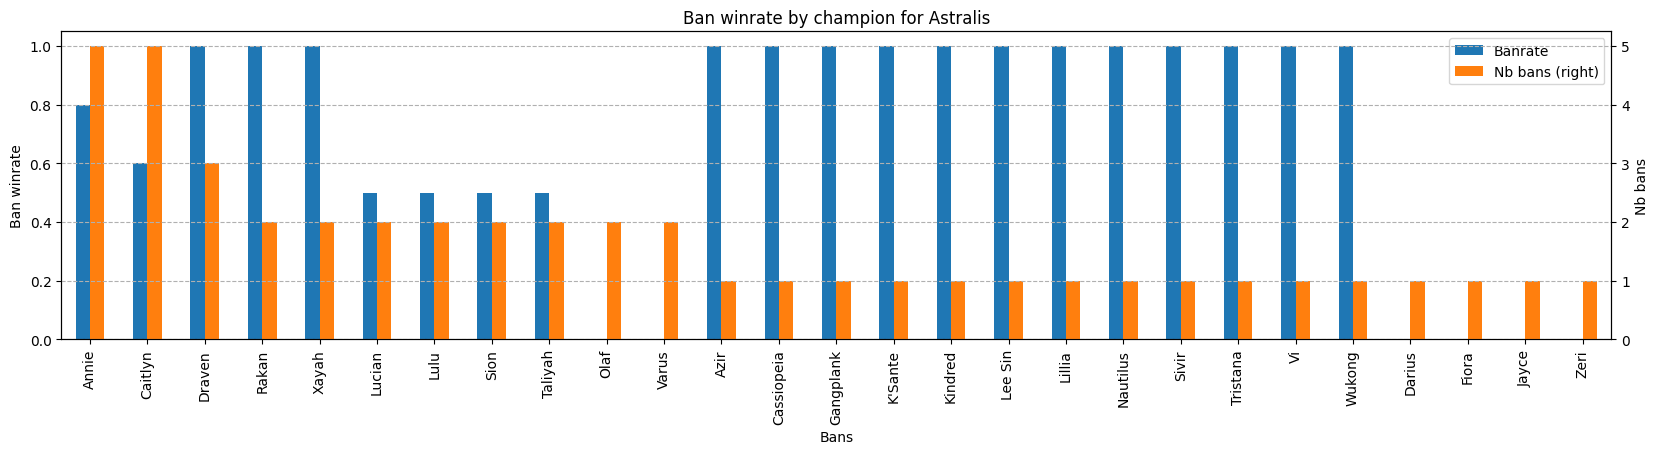

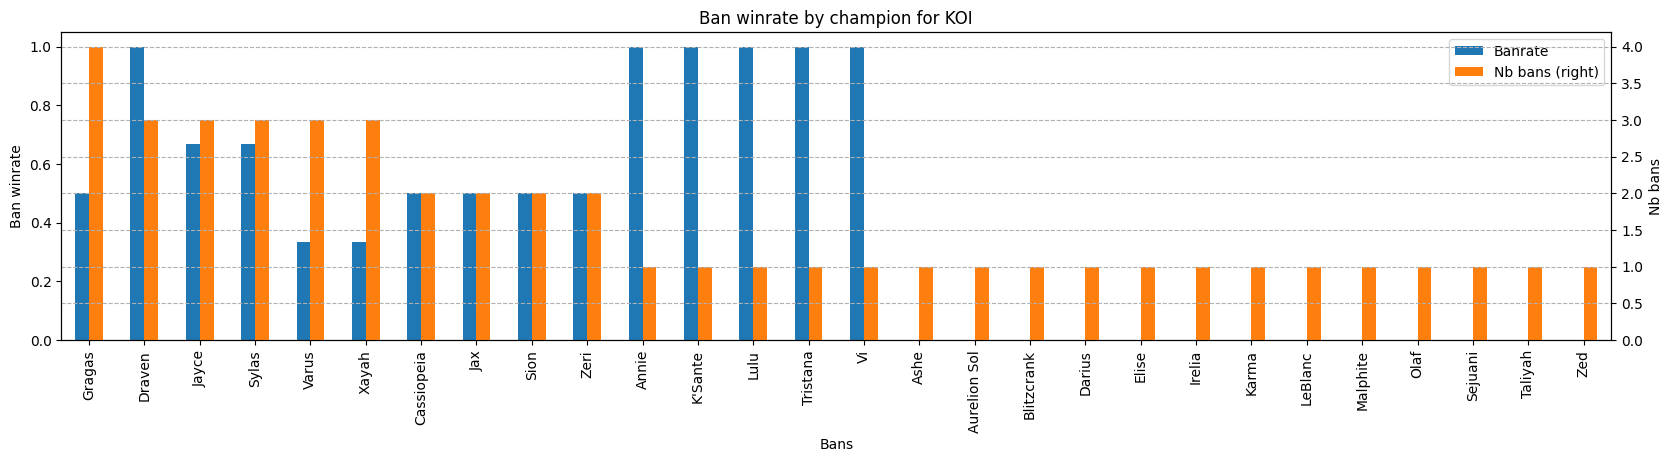

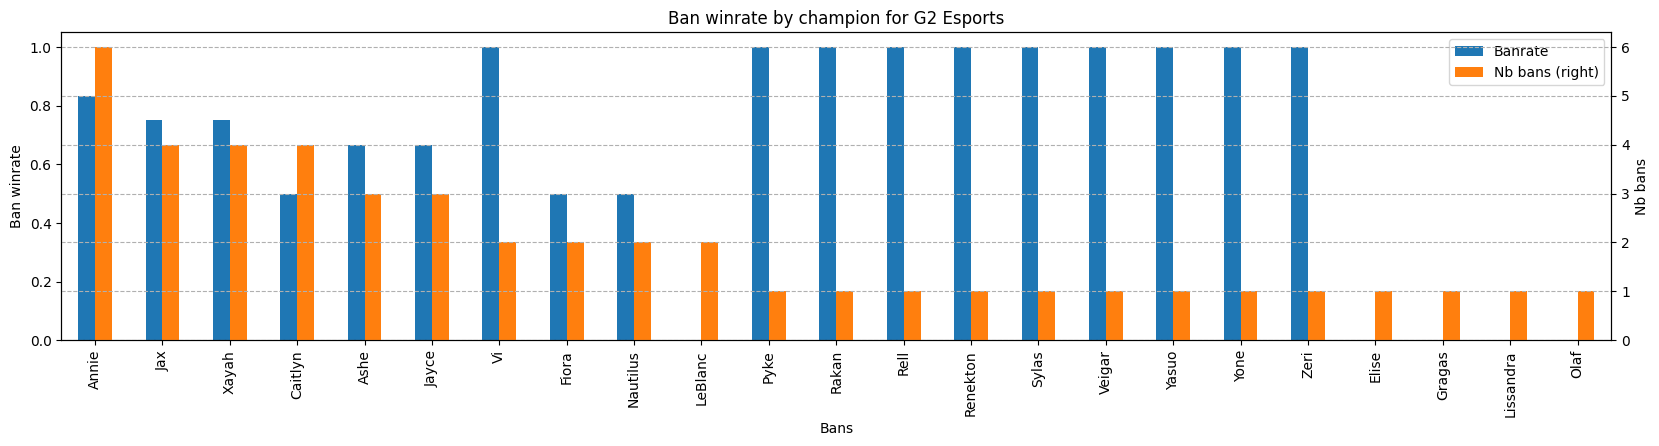

In [18]:
for team in teams:
    fig = ban_wr_by_team.loc[team].sort_values(
        ascending=False, 
        by=["Nb bans", "Banrate"]).plot(
            kind="bar", 
            figsize=(20, 4), 
            title=f"Ban winrate by champion for {team}", 
            stacked=False, 
            secondary_y="Nb bans",
            legend=True)
    
    fig.set_ylabel("Ban winrate")
    fig.right_ax.set_ylabel("Nb bans")
    plt.grid(axis="y", linestyle="--")
    plt.show()

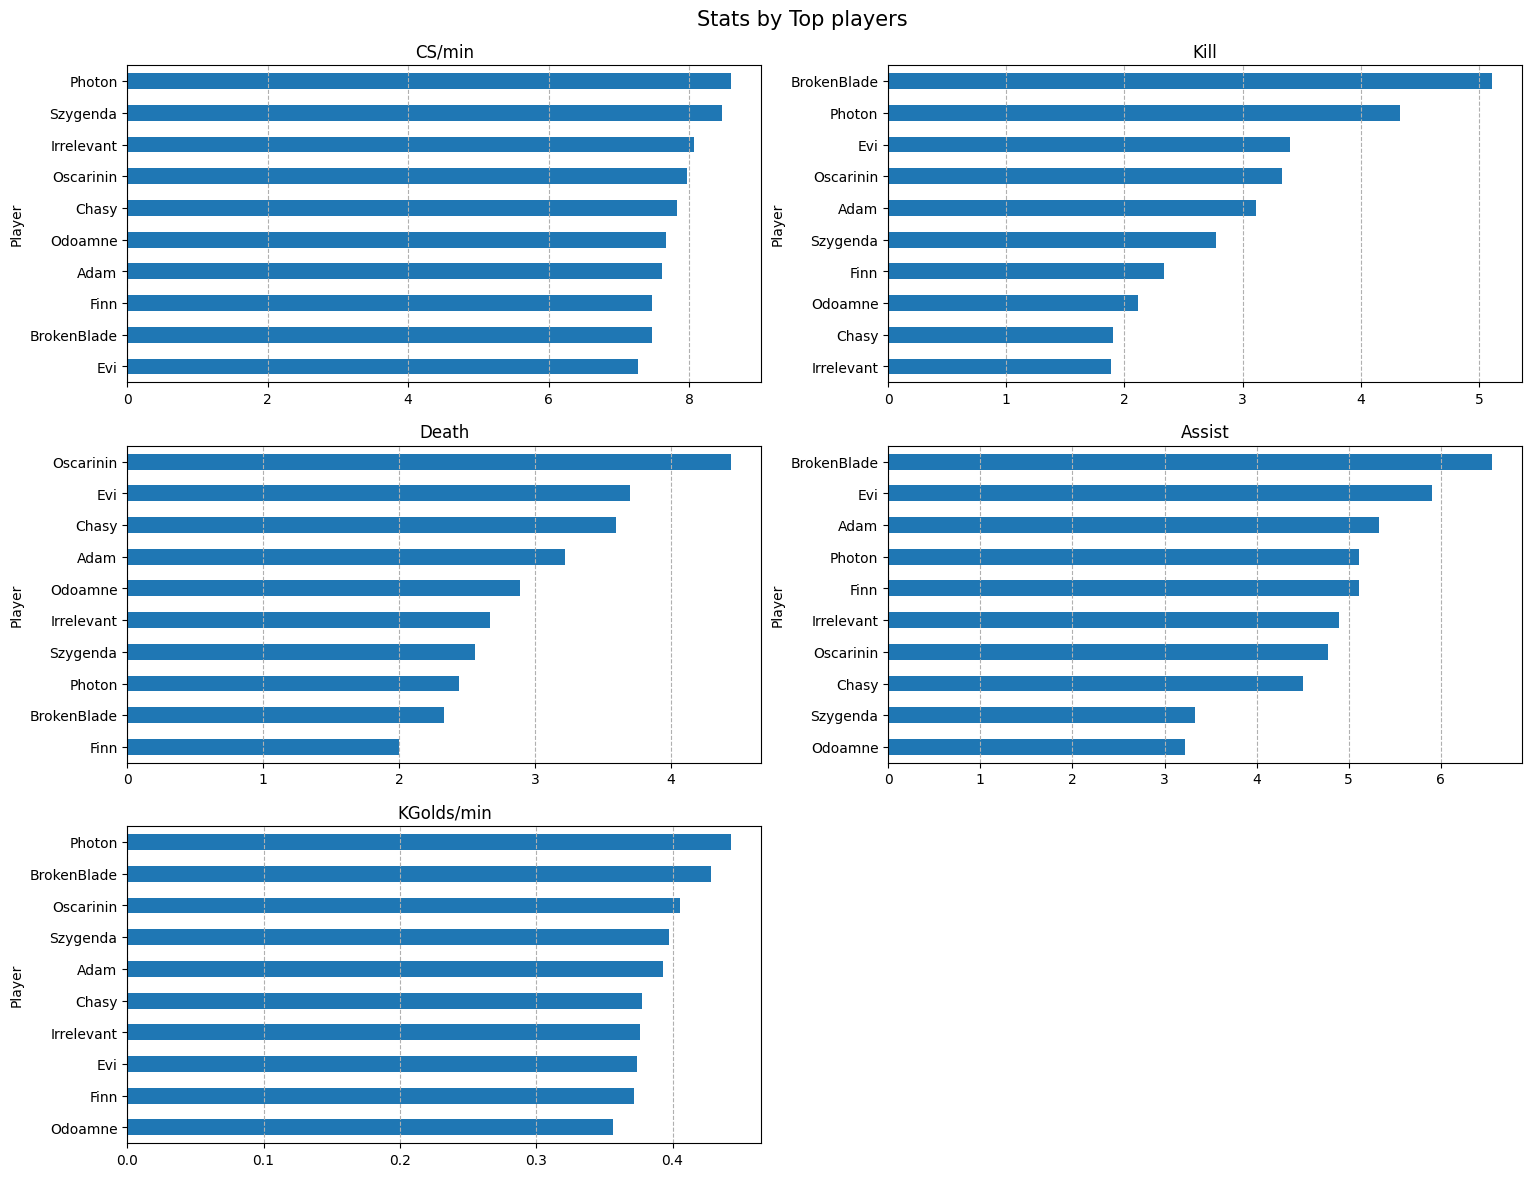

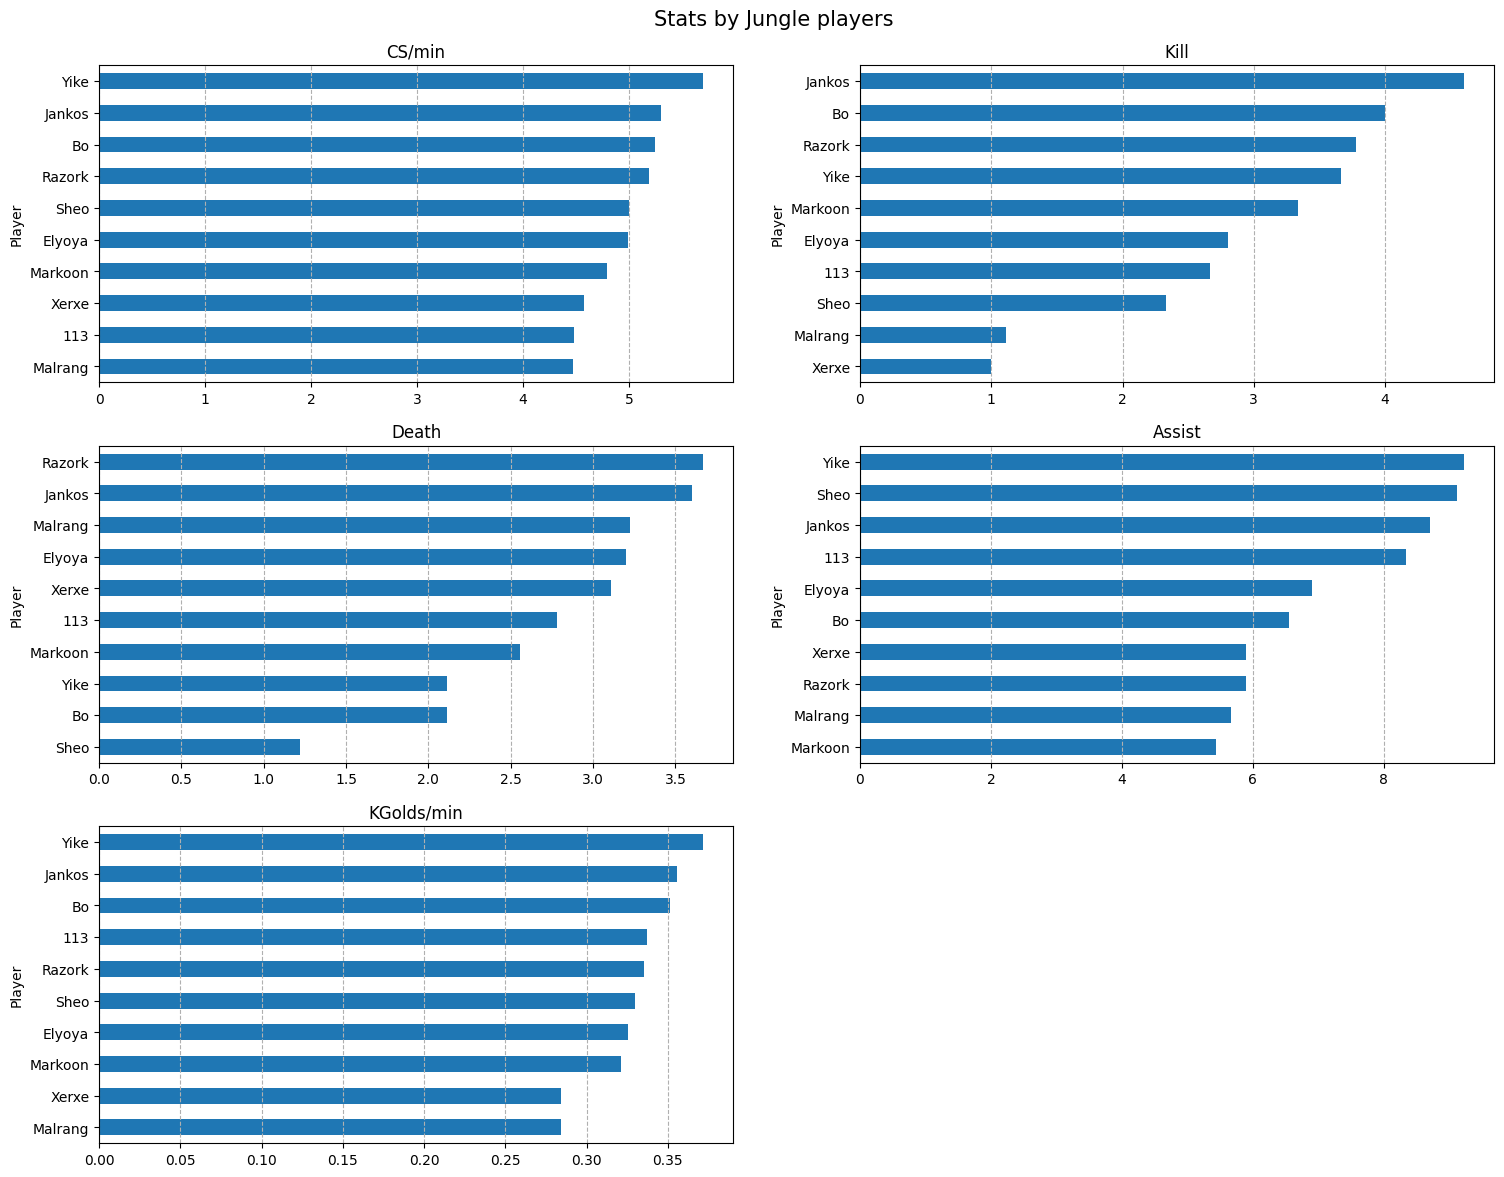

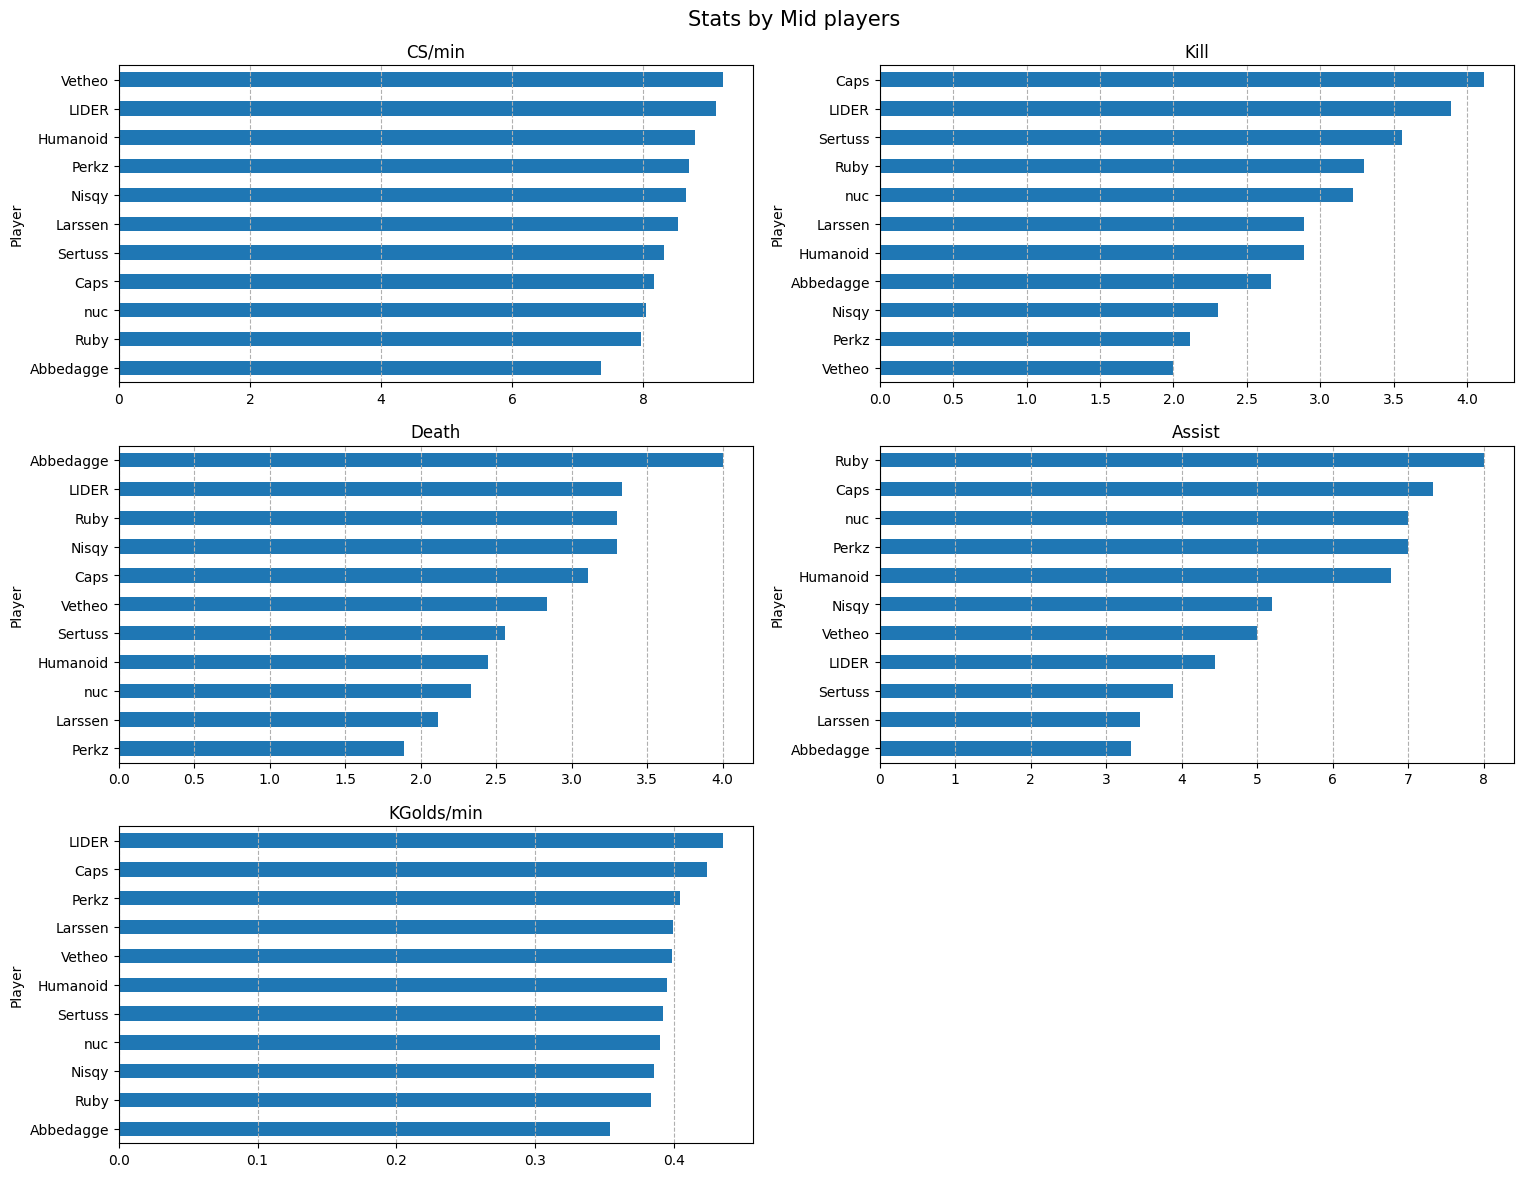

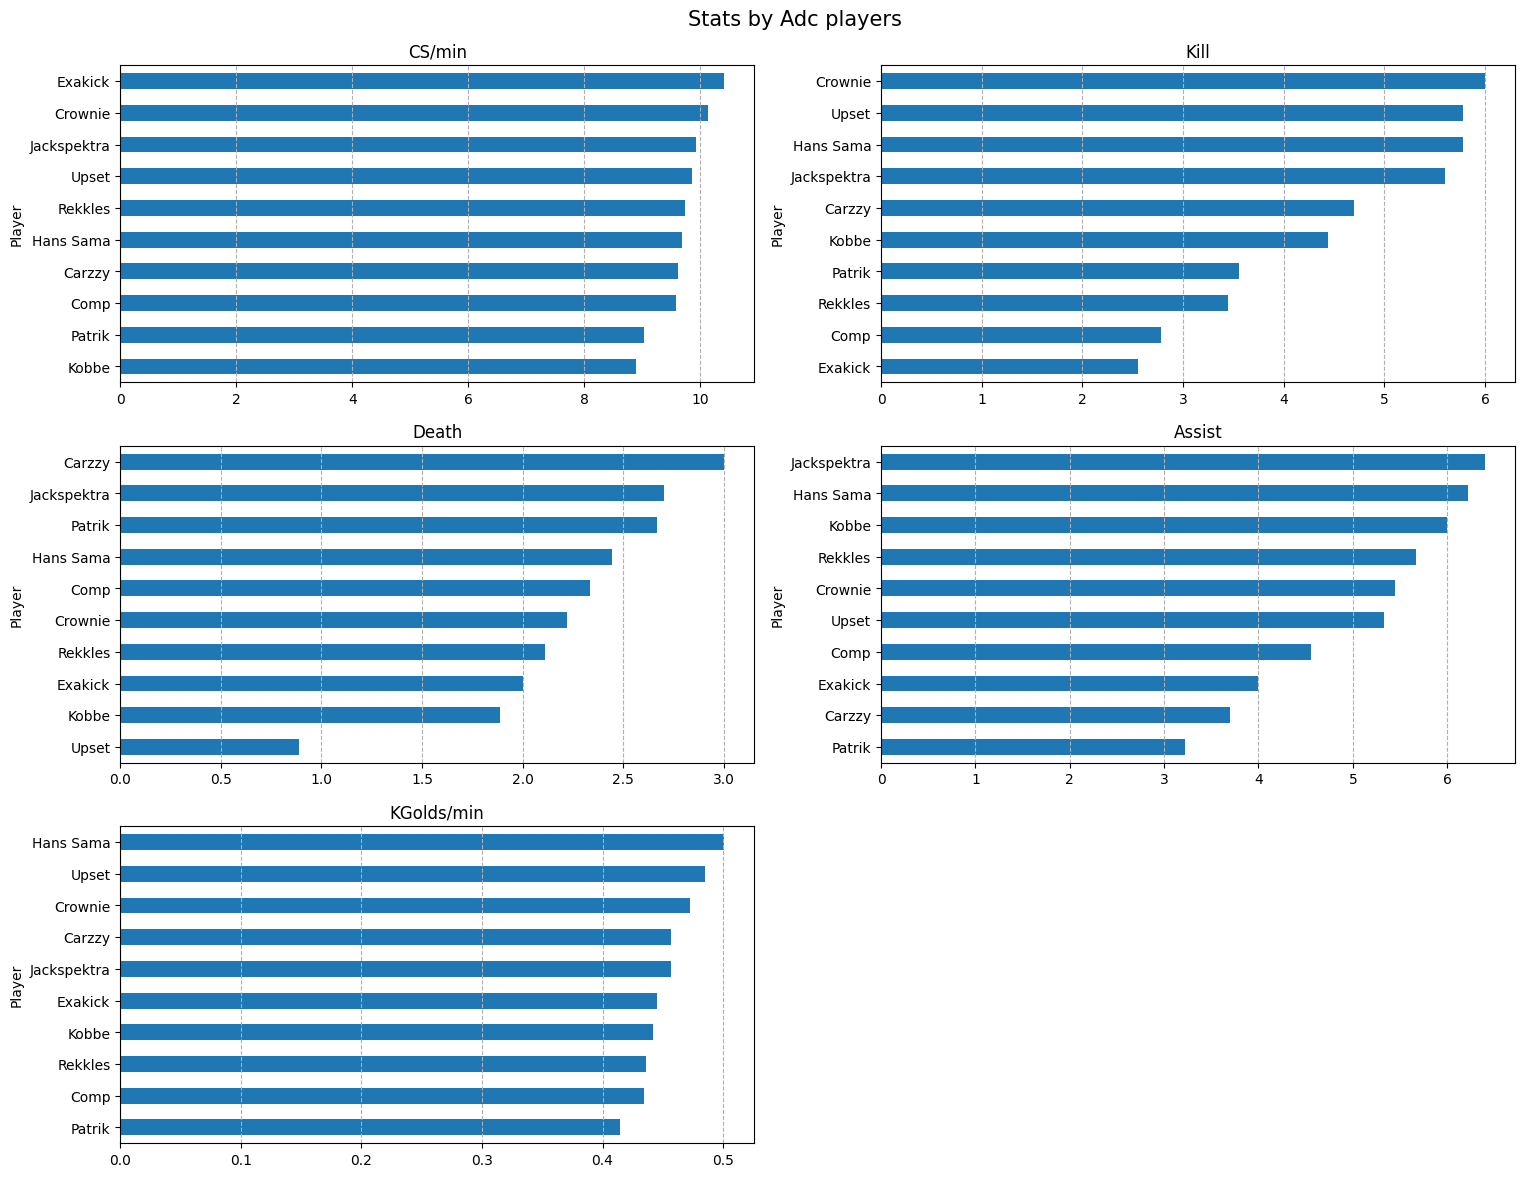

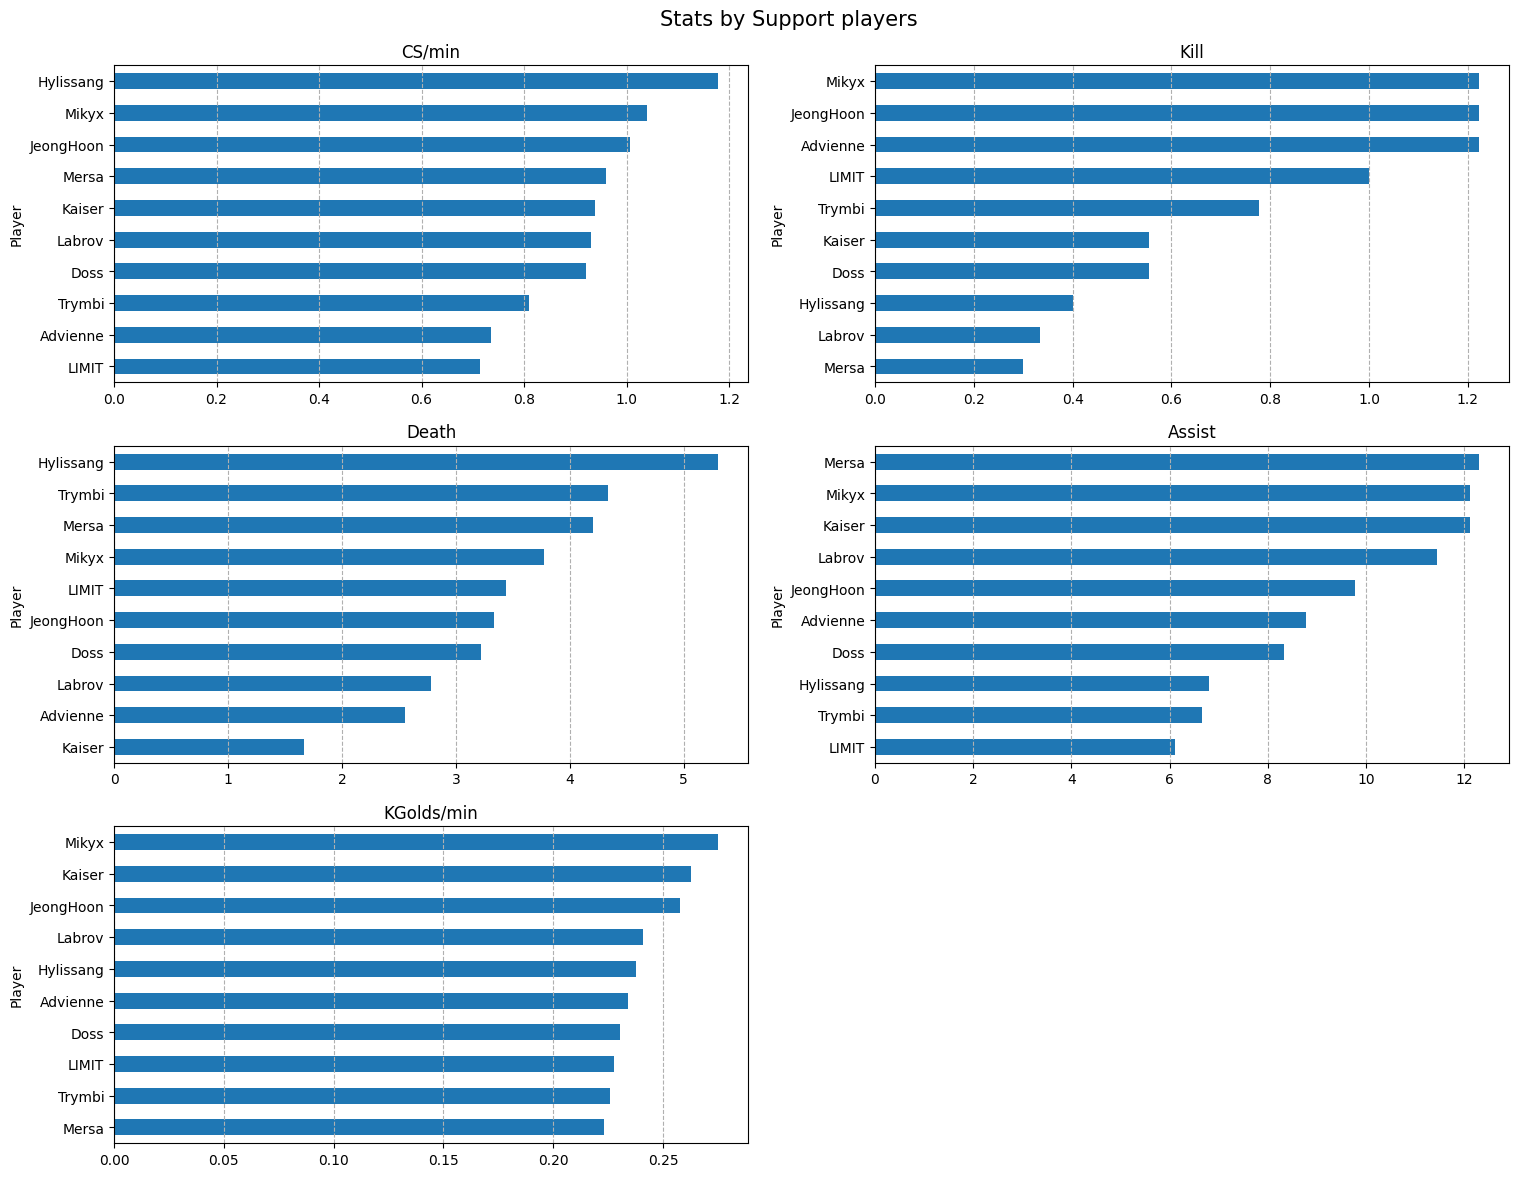

In [19]:
groups = ["CS/min", "Kill", "Death", "Assist", "KGolds/min"]
player_stats["CS/min"] = player_stats["CS"] / player_stats["Game time"]
player_stats["KGolds/min"] = player_stats["KGolds"] / player_stats["Game time"]

for poste in postes:     
    plt.figure(figsize=(18, 14))

    for k, group in enumerate(groups):
        plt.subplot(3, 2, k+1)

        if group == "CS/min":
            player_stats[(player_stats["Poste"] == poste) & (player_stats["Champion"] != "Senna")].groupby("Player")[group].mean().sort_values().plot.barh()
        else:
            player_stats[player_stats["Poste"] == poste].groupby("Player")[group].mean().sort_values().plot.barh()
        
        plt.grid(axis="x", linestyle="--")
        plt.title(group)
    
    plt.suptitle(f"Stats by {poste} players", y=0.92, size=15)
    plt.show()